In [1]:
! nvidia-smi

Tue Nov  1 14:13:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


torch.manual_seed(123)

In [3]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install gensim==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!python -m spacy download en_core_web_sm
!python -m spacy download ja_core_news_sm
!python -m spacy download fi_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 2.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ja_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.3 MB 1.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fi_core_news_sm')


In [6]:
! pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import gensim
import torchtext
import spacy
import numpy
import pandas
# import nni
import torch.utils.data as Data
from tqdm.autonotebook import tqdm
from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from matplotlib import pyplot as plt
from collections import OrderedDict
from sentence_transformers import SentenceTransformer

In [41]:
# epochs
epochs = 100
# batch size
batch_size = 128
# learning rate
lr = 0.0001


# model parameters
input_dim = 384
hidden_dim = 256
output_dim = 2

vocab = False
language_train = ["english"]
language_val = ["english"]
model_type = "regression"

In [9]:
if vocab:
    if language_train == ["english"]:
        tokenizer = spacy.load("en_core_web_sm")
    elif language_train == ["japanese"]:
        tokenizer = spacy.load("ja_core_news_sm")
    elif language_train == ["finnish"]:
        tokenizer = spacy.load("fi_core_news_sm")
    else:
        print("bow model cant be multilingual")


In [10]:
dataset = load_dataset("copenlu/answerable_tydiqa")
train_set = dataset["train"]
validation_set = dataset["validation"]

dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 116067
    })
    validation: Dataset({
        features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 13325
    })
})

In [11]:
def getLanguageDataSet(data, language):
    def printAndL(x):
        return x["language"] in language
    return data.filter(printAndL)


In [12]:
def build_vocab(dataSet, tokenizer):
    counter = Counter()
    for data in dataSet:
        counter.update([token.text for token in tokenizer(data['document_plaintext'])])
    return Vocab(counter)

In [13]:
def getWord2VecModel(train_dataSet, test_dataSet, tokenizer):
    sentences = []
    keys = ["document_plaintext", "question_text"]
    for element in train_dataSet:
        for key in keys:
            sentences.append([token.text for token in tokenizer(element[key])])
    for element in test_dataSet:
        for key in keys:
            sentences.append([token.text for token in tokenizer(element[key])])

    print(numpy.shape(sentences))
    
    w2v_model = gensim.models.Word2Vec(sentences, vector_size=128, min_count=1, window=10, epochs=5)

    return w2v_model

In [14]:
def data_process_vocab(dataSet, w2vModel, tokenizer, tokenPart="document"):
    data = []
    for element in tqdm(dataSet):
        if tokenPart == "document":
            en_tensor_ = torch.tensor([w2vModel.wv.get_vector(token) for token in [token_.text for token_ in tokenizer(element["document_plaintext"])]], dtype=torch.float32)
            en_tensor_ = torch.mean(en_tensor_, dim=0, keepdim=True).cuda()
            data.append(en_tensor_)
        elif tokenPart == "question":
            en_tensor_ = torch.tensor([w2vModel.wv.get_vector(token) for token in [token_.text for token_ in tokenizer(element["question_text"])]], dtype=torch.float32)
            en_tensor_ = torch.mean(en_tensor_, dim=0, keepdim=True).cuda()
            data.append(en_tensor_)
        elif tokenPart == "answer":
            if (element["annotations"]["answer_start"] == [-1]):
                data.append(torch.tensor([0], dtype=torch.int64).cuda())
            else:
                data.append(torch.tensor([1], dtype=torch.int64).cuda())
    return torch.cat(data, dim=0)

def data_process_sentence(dataSet, SbertModel, tokenPart="document"):
    data = []
    for element in tqdm(dataSet):
        if tokenPart == "document":
            en_tensor_ = torch.tensor([SbertModel.encode(element["document_plaintext"])], dtype=torch.float32).cuda()
            data.append(en_tensor_)
        elif tokenPart == "question":
            en_tensor_ = torch.tensor([SbertModel.encode((element["question_text"]))], dtype=torch.float32).cuda()
            data.append(en_tensor_)
        elif tokenPart == "answer":
            if (element["annotations"]["answer_start"] == [-1]):
                data.append(torch.tensor([0], dtype=torch.int64).cuda())
            else:
                data.append(torch.tensor([1], dtype=torch.int64).cuda())
    return torch.cat(data, dim=0)


In [15]:
def getData(data, language):
    print("get data:")
    dataset = getLanguageDataSet(data, language)
    if vocab:
        print("bow model:")
        tokenizer = tokenizer
        # englishVocab = build_vocab(dataset, tokenizer)
        model = getWord2VecModel(train_set, validation_set, tokenizer)
        answer_set = data_process_vocab(dataset, model, tokenizer, "answer")
        question_set = data_process_vocab(dataset, model, tokenizer, "question")
        document_set = data_process_vocab(dataset, model, tokenizer, "document")
    else:
        print("sentence model:")
        model = SentenceTransformer('all-MiniLM-L6-v2')
        answer_set = data_process_sentence(dataset, model, "answer")
        question_set = data_process_sentence(dataset, model, "question")
        document_set = data_process_sentence(dataset, model, "document")
    
    return answer_set, question_set, document_set


In [16]:
# train_set
answer_train_set, question_train_set, document_train_set = getData(train_set, language_train)
# val_set
answer_validation_set, question_validation_set, document_validation_set = getData(validation_set, language_val)


get data:


  0%|          | 0/117 [00:00<?, ?ba/s]

sentence model:


  0%|          | 0/7389 [00:00<?, ?it/s]

  0%|          | 0/7389 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


  0%|          | 0/7389 [00:00<?, ?it/s]

get data:


  0%|          | 0/14 [00:00<?, ?ba/s]

sentence model:


  0%|          | 0/990 [00:00<?, ?it/s]

  0%|          | 0/990 [00:00<?, ?it/s]

  0%|          | 0/990 [00:00<?, ?it/s]

In [17]:
# dataloader
torch_dataset = Data.TensorDataset(question_train_set, document_train_set, answer_train_set)
train_loader = Data.DataLoader(dataset=torch_dataset, batch_size=batch_size, shuffle=True)


In [18]:
class attention(nn.Module):
    def __init__(self, hidden_dim, attn_drop):
        super(attention, self).__init__()
        self.fc = nn.Linear(hidden_dim, hidden_dim, bias=True)
        nn.init.xavier_normal_(self.fc.weight, gain=1.414)

        self.tanh = nn.Tanh()
        self.att = nn.Parameter(torch.empty(size=(1, hidden_dim)), requires_grad=True)
        nn.init.xavier_normal_(self.att.data, gain=1.414)

        self.softmax = nn.Softmax()
        if attn_drop:
            self.attn_drop = nn.Dropout(attn_drop)
        else:
            self.attn_drop = lambda x: x

    def forward(self, embeds):
        beta = []
        attn_curr = self.attn_drop(self.att)
        for embed in embeds:
            sp = self.tanh(self.fc(embed)).mean(dim=0)
            beta.append(attn_curr.matmul(sp.t()))
        beta = torch.cat(beta, dim=-1).view(-1)
        beta = self.softmax(beta)
        #print(ntype+" mp ", beta.data.cpu().numpy())  # semantic attention
        z_mp = 0
        for i in range(len(embeds)):
            z_mp = z_mp+ embeds[i]*beta[i]
        return z_mp


In [39]:
class QA_model(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(QA_model, self).__init__()
        self.que_in_mlp = nn.Linear(input_dim,hidden_dim)
        self.context_in_mlp = nn.Linear(input_dim,hidden_dim)
        self.output_layer = nn.Linear(hidden_dim,output_dim)
        self.attention_layer = attention(hidden_dim,0.5)

    def forward(self,question,context):
        q_vec = F.leaky_relu(self.que_in_mlp(question))
        c_vec = F.leaky_relu(self.context_in_mlp(context))
        attention_out = self.attention_layer([q_vec,c_vec])
        predict_label = self.output_layer(attention_out)

        return predict_label

class QA_LR_model(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(QA_LR_model, self).__init__()
        self.input_layer = nn.Linear(input_dim*2,hidden_dim)
        self.relu_0 = nn.ReLU()
        self.hidden_layer_0 = nn.Linear(hidden_dim,hidden_dim*2)
        self.relu_1 = nn.ReLU()
        self.hidden_layer_1 = nn.Linear(hidden_dim*2,hidden_dim)
        self.relu_2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim,output_dim)

    def forward(self,data):
        input = self.input_layer(data)
        relu_0 = self.relu_0(input)
        hidden_0 = self.hidden_layer_0(relu_0)
        relu_1 = self.relu_1(hidden_0)
        hidden_1 = self.hidden_layer_1(relu_1)
        relu_2 = self.relu_2(hidden_1)
        output = F.sigmoid(self.output_layer(relu_2))

        return output


In [42]:
if model_type == "regression":
    # LR model define
    model = QA_LR_model(input_dim, hidden_dim, output_dim).to('cuda')
else:
    # attention model define
    model = QA_model(input_dim, hidden_dim, output_dim).to('cuda')

# show model structure
print(model)


QA_model(
  (que_in_mlp): Linear(in_features=384, out_features=256, bias=True)
  (context_in_mlp): Linear(in_features=384, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
  (attention_layer): attention(
    (fc): Linear(in_features=256, out_features=256, bias=True)
    (tanh): Tanh()
    (softmax): Softmax(dim=None)
    (attn_drop): Dropout(p=0.5, inplace=False)
  )
)


In [43]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 0 loss: 0.6875 acc: 0.5591397849462365
epoch: 5 loss: 0.555 acc: 0.7634408602150538
epoch: 10 loss: 0.4511 acc: 0.7956989247311828
epoch: 15 loss: 0.5078 acc: 0.7741935483870968
epoch: 20 loss: 0.3815 acc: 0.8172043010752689
epoch: 25 loss: 0.4864 acc: 0.7956989247311828
epoch: 30 loss: 0.4937 acc: 0.7526881720430108
epoch: 35 loss: 0.4145 acc: 0.8387096774193549
epoch: 40 loss: 0.4535 acc: 0.7419354838709677
epoch: 45 loss: 0.4055 acc: 0.8387096774193549
epoch: 50 loss: 0.4781 acc: 0.7634408602150538
epoch: 55 loss: 0.5251 acc: 0.7526881720430108
epoch: 60 loss: 0.541 acc: 0.7956989247311828
epoch: 65 loss: 0.4155 acc: 0.8494623655913979
epoch: 70 loss: 0.4491 acc: 0.7419354838709677
epoch: 75 loss: 0.4341 acc: 0.7849462365591398
epoch: 80 loss: 0.5979 acc: 0.7634408602150538
epoch: 85 loss: 0.4212 acc: 0.8494623655913979
epoch: 90 loss: 0.391 acc: 0.8387096774193549
epoch: 95 loss: 0.3881 acc: 0.8064516129032258
max acc: 0.9296875


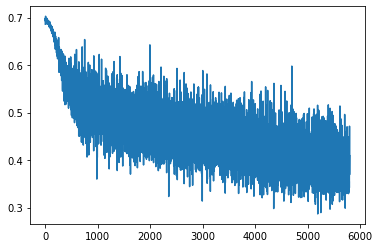

In [44]:
# train
max_acc = 0
loss_list = []
for epoch in tqdm(range(epochs)):
    model.train()
    batch_num = 0
    for question_vec, document_vec, label in train_loader:
        if model_type == "regression":
            data = torch.cat((question_vec, document_vec), 1)
            predict_label = model(data)
        else:
            predict_label = model(question_vec, document_vec)
        
        loss = criterion(predict_label, label)

        pred = predict_label.max(-1, keepdim=True)[1]
        acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]
        optimizer.zero_grad()
        if (acc > max_acc):
            max_acc = acc
            torch.save(model.state_dict(), 'model.pth')
        loss.backward()
        optimizer.step()
        batch_num += 1
        loss_list.append(round(loss.item(), 4))
    if epoch % 5 == 0:
        print("epoch:", epoch, "loss:", round(loss.item(), 4), "acc:", acc)
print("max acc:", max_acc)

plt.cla()
plt.plot(loss_list)

In [37]:
from sklearn.metrics import classification_report

In [45]:
model.load_state_dict(torch.load("model.pth"))

if model_type == "regression":
    predict_label = model(torch.cat((question_validation_set, document_validation_set), 1))
else:
    predict_label = model(question_validation_set, document_validation_set)
pred = predict_label.max(-1, keepdim=True)[1]
label = answer_validation_set
test_acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]

report = classification_report(label.cpu(), pred.cpu(), output_dict=True)
print(pandas.DataFrame(report).transpose())

print("\ntest acc:", test_acc)

              precision    recall  f1-score     support
0              0.755411  0.705051  0.729363  495.000000
1              0.723485  0.771717  0.746823  495.000000
accuracy       0.738384  0.738384  0.738384    0.738384
macro avg      0.739448  0.738384  0.738093  990.000000
weighted avg   0.739448  0.738384  0.738093  990.000000

test acc: 0.7383838383838384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
